Running train UNet
Training model from scratch
Epoch 1/10 - Loss: 152.5346, Val IoU: 0.9053, Val Dice: 0.9468
Epoch 2/10 - Loss: 81.8416, Val IoU: 0.9235, Val Dice: 0.9571
Epoch 3/10 - Loss: 68.9769, Val IoU: 0.9350, Val Dice: 0.9637
Epoch 4/10 - Loss: 61.7931, Val IoU: 0.9392, Val Dice: 0.9662
Epoch 5/10 - Loss: 58.8823, Val IoU: 0.9376, Val Dice: 0.9652
Epoch 6/10 - Loss: 55.5032, Val IoU: 0.9398, Val Dice: 0.9664
Epoch 7/10 - Loss: 52.5185, Val IoU: 0.9405, Val Dice: 0.9666
Epoch 8/10 - Loss: 50.7812, Val IoU: 0.9458, Val Dice: 0.9698
Epoch 9/10 - Loss: 48.6423, Val IoU: 0.9467, Val Dice: 0.9705
Epoch 10/10 - Loss: 46.9816, Val IoU: 0.9492, Val Dice: 0.9720
Model saved to unet_model.pkl


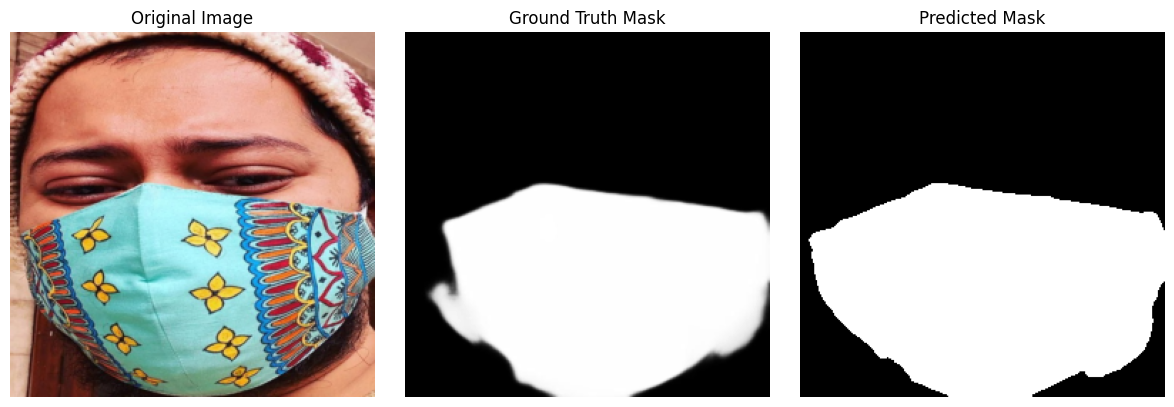

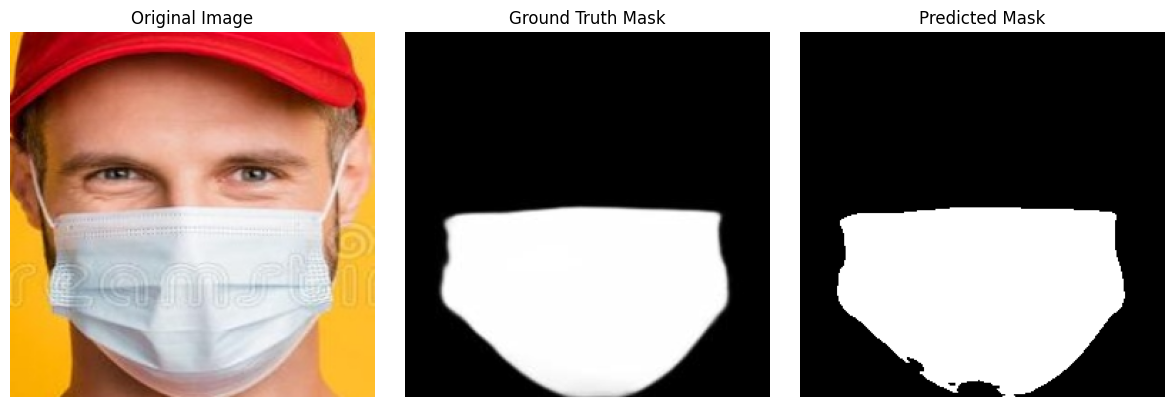

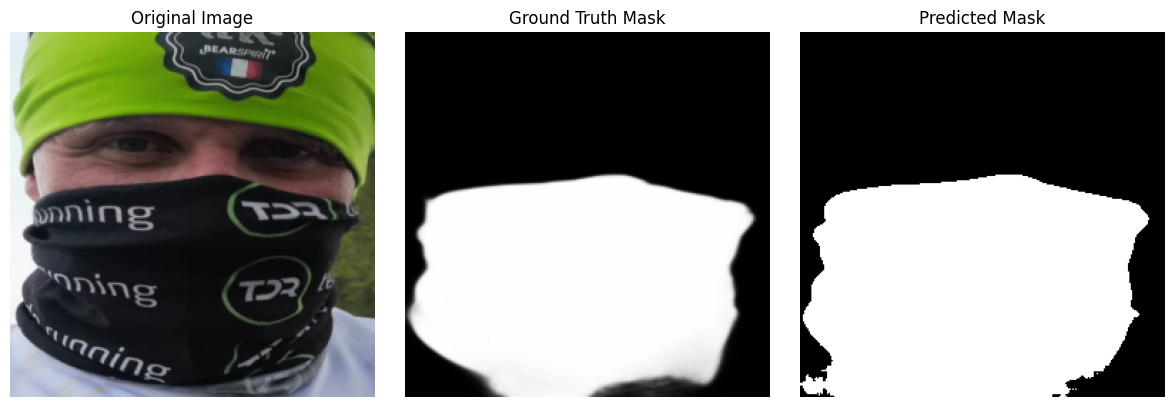

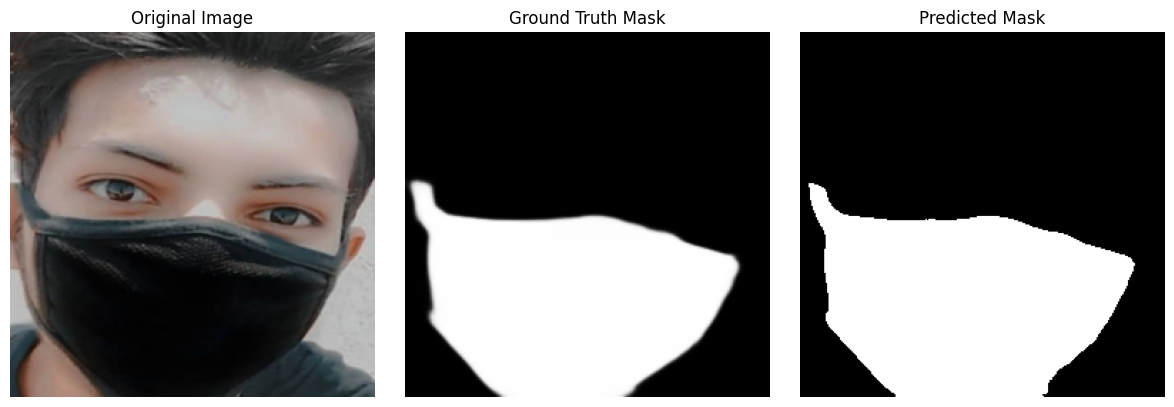

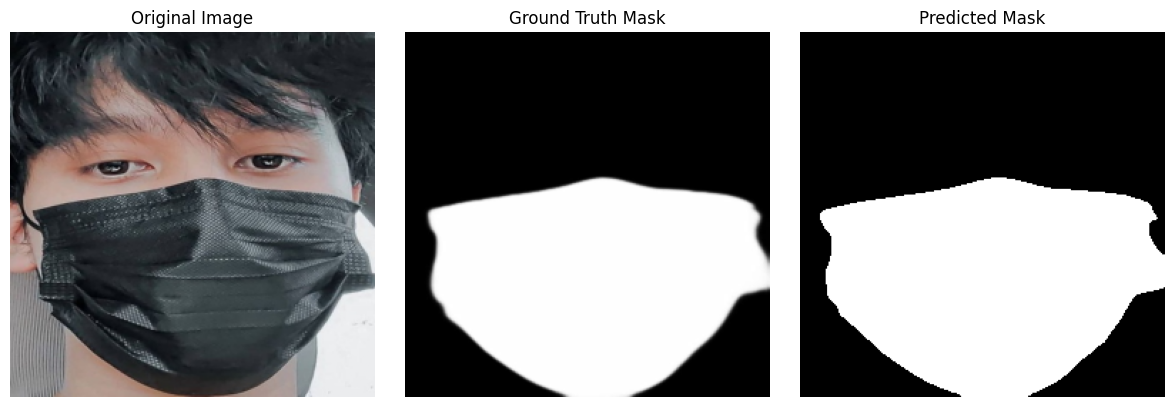

In [ ]:
import zipfile
import os
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Define transforms
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

# UNet model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)
        self.enc5 = self.double_conv(512, 1024)

        self.pool = nn.MaxPool2d(2, 2)

        self.up4 = self.upconv(1024, 512)
        self.dec4 = self.double_conv(1024, 512)

        self.up3 = self.upconv(512, 256)
        self.dec3 = self.double_conv(512, 256)

        self.up2 = self.upconv(256, 128)
        self.dec2 = self.double_conv(256, 128)

        self.up1 = self.upconv(128, 64)
        self.dec1 = self.double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        enc5 = self.enc5(self.pool(enc4))

        x = self.up4(enc5)
        x = torch.cat([x, enc4], dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec1(x)

        return self.final_conv(x)

class FaceDataset(Dataset):
    def __init__(self, csv_file, face_crop_dir, face_segmentation_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.face_crop_dir = face_crop_dir
        self.face_segmentation_dir = face_segmentation_dir
        self.transform = transform
        self.data = self.data[self.data['with_mask'] == 1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['filename'].replace('.jpg', '_1.jpg')
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        img_path = os.path.join(self.face_crop_dir, img_name)
        mask_path = os.path.join(self.face_segmentation_dir, img_name)

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            return None  

        try:
            img = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')

            if self.transform:
                img = self.transform(img)
                mask = self.transform(mask)
            return img, mask
        except:
            return None 

def custom_collate_fn(batch):
    batch = [b for b in batch if b is not None]
    return torch.utils.data.dataloader.default_collate(batch)

def dice_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > threshold
    intersection = (pred & target).float().sum((1, 2, 3))
    union = pred.float().sum((1, 2, 3)) + target.float().sum((1, 2, 3))
    dice = (2. * intersection + 1e-8) / (union + 1e-8)
    return dice.mean().item()

def iou_score(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred) > threshold
    target = target > threshold
    intersection = (pred & target).float().sum((1, 2, 3))
    union = (pred | target).float().sum((1, 2, 3))
    iou = (intersection + 1e-8) / (union + 1e-8)
    return iou.mean().item()

def train_unet(model, train_loader, val_loader, optimizer, device, num_epochs=3):
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        with torch.no_grad():
            val_iou, val_dice = 0.0, 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_iou += iou_score(outputs, masks)
                val_dice += dice_score(outputs, masks)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}, "
              f"Val IoU: {val_iou/len(val_loader):.4f}, Val Dice: {val_dice/len(val_loader):.4f}")

csv_file = '/kaggle/input/mfsd-dataset/MSFD/1/dataset.csv'
face_crop_dir = '/kaggle/input/mfsd-dataset/MSFD/1/face_crop'
face_segmentation_dir = '/kaggle/input/mfsd-dataset/MSFD/1/face_crop_segmentation'

transform = get_transforms()
full_dataset = FaceDataset(csv_file, face_crop_dir, face_segmentation_dir, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=custom_collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Running train UNet")

import matplotlib.pyplot as plt

MODEL_PATH = "unet_model.pkl"

# Load or train model
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
else:
    print("Training model from scratch")
    train_unet(model, train_loader, val_loader, optimizer, device, num_epochs=10)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Model saved to {MODEL_PATH}")

model.eval()
samples_shown = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Threshold

        for i in range(images.shape[0]):
            if samples_shown >= 5:
                break
            img_np = images[i].cpu().permute(1, 2, 0).numpy()
            gt_mask = masks[i].squeeze().cpu().numpy()
            pred_mask = preds[i].squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img_np)
            axs[0].set_title("Original Image")
            axs[0].axis('off')

            axs[1].imshow(gt_mask, cmap='gray')
            axs[1].set_title("Ground Truth Mask")
            axs[1].axis('off')

            axs[2].imshow(pred_mask, cmap='gray')
            axs[2].set_title("Predicted Mask")
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()
            samples_shown += 1

        if samples_shown >= 5:
            break

